# Coursework 2: Neural Networks 

This coursework covers the topics covered in class regarding neural networks for image classification.

This coursework includes both coding questions as well as written ones. Please upload the notebook, which contains your code, results and answers as a pdf file onto Cate.

Dependencies: If you work on a college computer in the Computing Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where relevant Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_ubuntu18.04/bin/activate`

Alternatively, you can use pip, pip3 or anaconda etc to install Python packages.

**Note 1:** please read the both the text and code comment in this notebook to get an idea what you are supposed to implement.

**Note 2:** If you are using the virtual environment in the Computing Lab, please run the following command in the command line before opening jupyter-notebook and importing tensorflow. This will tell tensorflow where the Nvidia CUDA libariries are.

`export LD_LIBRARY_PATH=/vol/cuda/9.0.176/lib64/:"${LD_LIBRARY_PATH}}"` 

In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
import collections
import itertools
from PIL import Image

Using TensorFlow backend.


## Question 1 (20 points)

Throughout this coursework you will be working with the Fashion-MNIST dataset. If you are interested, you may find relevant information regarding the dataset in this paper.

[1] Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

Be sure that you have the following files in your working directory: data.tar.gz and reader.py. Loading the data can be done as follows:

`from reader import get_images
(x_train, y_train), (x_test, y_test) = get_images()`

The dataset is already split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels and stored as 784-D vector. So if you would like to visualise the images, you need to reshape the array.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

### 1.1 Load data (6 points)
Load the dataset and print the dimensions of the training set and the test set.

In [2]:
from reader import get_images
(x_train, y_train), (x_test, y_test) = get_images()
print ("Dimensions of the training set is %s with %s labels" % (str(x_train.shape), str(y_train.shape[0])))
print ("Dimensions of the test set is %s with %s labels" % (str(x_test.shape), str(y_test.shape[0])))

Dimensions of the training set is (60000, 784) with 60000 labels
Dimensions of the test set is (10000, 784) with 10000 labels


### 1.2 Visualize data (6 points)
Visualise 3 training images (T-shirt, trousers and pullover) and 3 test images (dress, coat and sandal).

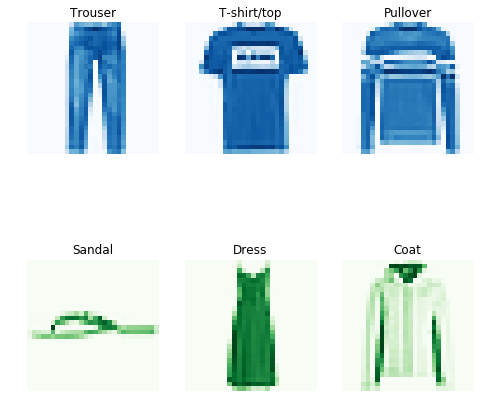

In [3]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

# https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist#

f, ax = plt.subplots(2, 3, figsize=(8, 8))
# 1, 5, 16 for train
# 6, 8, 13 for test
train_index = set([1, 5, 16])
test_index = set([6, 8, 13])
ite = set([0, 1, 2])
for i, j, k in zip(ite, train_index, test_index):
    ax[0, i].imshow(x_train[j].reshape(28, 28), cmap="Blues")
    ax[0, i].axis('off')
    ax[0, i].set_title(labels[y_train[j]])
    
    ax[1, i].imshow(x_test[k].reshape(28, 28), cmap="Greens")
    ax[1, i].axis('off')
    ax[1, i].set_title(labels[y_test[k]])
    
plt.show()

### 1.3 Data balance (4 points)
Print out the number of training samples for each class.

In [4]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = collections.Counter(data)

    # Get total number of samples
    total_samples = len(data)
    
    samp_values = list(label_counts.values())
    samp_keys = list(label_counts.keys())

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[samp_keys[i]]
        count = samp_values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(y_train)

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


### 1.4 Discussion (4 points)
Is the dataset balanced? What would happen if the dataset is not balanced in the context of image classification? 

The dataset is balanced, as each category is represented by 10%. If the dataset is not balanced, then the set will be biased towards a certain image classification. This would mean that it would favor the output of a certain label.

## Question 2 (40 points)

Build a neural network and train it with the Fashion-MNIST dataset. Here, we use the keras library, which is a high-level neural network library built upon tensorflow.

In [5]:
# Convert the label class into a one-hot representation
# 10 for the number of labels.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 2.1 Build a multi-layer perceptron, also known as multi-layer fully connected network. You need to define the layers, the loss function, the optimiser and evaluation metric. (30 points)

In [12]:
model = keras.models.Sequential()

model.add(Dense(784, input_dim=784))
model.add(Dropout(0.50))
model.add(Activation('relu'))
model.add(Dense(500))
#model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_4 (Dropout)          (None, 784)               0         
_________________________________________________________________
activation_13 (Activation)   (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               392500    
_________________________________________________________________
activation_14 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 150)               75150     
_________________________________________________________________
activation_15 (Activation)   (None, 150)               0         
__________

### 2.2 Define the optimisation parameters including the batch size and the number of epochs and then run the optimiser. (10 points)

We have tested that for an appropriate network architecture, on a personal laptop and with only CPU, it takes about a few seconds per epoch to train the network. For 100 epochs, it takes about a coffee break's time to finish the training. If you run it on a powerful GPU, it would be even much faster.

In [ ]:
batch_size = 1000
epochs = 100
model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/100
60000/60000 [==============================] - 3s 52us/step - loss: 11.8887 - acc: 0.2605
Epoch 2/100
60000/60000 [==============================] - 3s 49us/step - loss: 9.6994 - acc: 0.3954
Epoch 3/100
60000/60000 [==============================] - 3s 49us/step - loss: 8.6862 - acc: 0.4587
Epoch 4/100
60000/60000 [==============================] - 3s 49us/step - loss: 8.5278 - acc: 0.4686
Epoch 5/100
60000/60000 [==============================] - 3s 49us/step - loss: 7.8528 - acc: 0.5077
Epoch 6/100
60000/60000 [==============================] - 3s 49us/step - loss: 7.1770 - acc: 0.5494
Epoch 7/100
60000/60000 [==============================] - 3s 50us/step - loss: 6.7745 - acc: 0.5739
Epoch 8/100
60000/60000 [==============================] - 3s 49us/step - loss: 6.6201 - acc: 0.5843
Epoch 9/100
60000/60000 [==============================] - 3s 50us/step - loss: 6.5019 - acc: 0.5921
Epoch 10/100
60000/60000 [==============================] - 3s 50us/step - loss: 6.3200 - 

60000/60000 [==============================] - 3s 50us/step - loss: 0.3400 - acc: 0.8723
Epoch 82/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.3385 - acc: 0.8738
Epoch 83/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.3403 - acc: 0.8733
Epoch 84/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.3334 - acc: 0.8760
Epoch 85/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.3361 - acc: 0.8750
Epoch 86/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.3355 - acc: 0.8765
Epoch 87/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.3306 - acc: 0.8759
Epoch 88/100
44000/60000 [=====================>........] - ETA: 0s - loss: 0.3335 - acc: 0.8750

## Question 3 (20 points) 

Evaluate the performance of your network with the test data. 
Visualize the performance using appropriate metrics and graphs (eg. confusion matrix). 
Comment on your per class performance and how it could be better.

In [ ]:
# This function is provided for you to display the confusion matrix.
# For more information about the confusion matrix, you can read at
# https://en.wikipedia.org/wiki/Confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        
        cm: confusion matrix, default to be np.int32 data type
        classes: a list of the class labels or class names
        normalize: normalize the matrix so that each row amounts to one
        cmap: color map
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    cm = cm.astype(int)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### 3.1 Evaluate the classification accuracy on the test set (10 points)

In [ ]:
loss, metric = model.evaluate(x = x_test, y = y_test)
print(loss)
print(metric)

### 3.2 Calculate and plot the confusion matrix (10 points)

In [ ]:
predictions = model.predict(x_test)
matrix = np.zeros((10, 10))

for i in range(len(predictions)):
    maxp = np.argmax(predictions[i])
    actual = np.argmax(y_test[i])
    matrix[maxp][actual] += 1
    
plot_confusion_matrix(matrix, list(labels.values()))

## Question 4 (20 points)
Take two photos, one of your clothes or shoes that belongs to one of 10 classes, the other that does not belong to any class.

Use either Python or other software (Photoshop, Gimp, or any image editer) to convert the photos into grayscale, crop the region of interest and reshape into the size of 28x28.

### 4.1 Load and visualise your own images (6 points)

In [ ]:
#airforce = tf.image.decode_jpeg('airforce.jpg')
#rayban = tf.image.decode_jpeg('rayban.jpg')
#resized_airforce = tf.image.resize_images(airforce, [28, 28])
#resized_rayban = tf.image.resize_images(rayban, [28, 28])
#gray_airforce = tf.image.rgb_to_grayscale(resized_airforce)
#gray_rayban = tf.image.rgb_to_grayscale(resized_rayban)

#sess = tf.InteractiveSession()
#gray_airforce.eval()

### 4.2 Test your network on the two images and show the classification results (10 points)

### 4.3 Discuss the classification results and provide one method to improve real life performance of the network (4 points)

## 5. Survey
How long did the coursework take you to solve? 